## CNN for Text Classification
Implementation of *Convolutional Neural Networks for Sentence Classification* (Yoon Kim, 2014).

In his [paper](https://arxiv.org/abs/1408.5882), Yoon Kim proposed several techniques to achieve good text classification accuracy with minimal hyper-parameter tuning.

This notebook consist of 4 main sections:

1. Preparing the data
2. Implementing Yoon Kim's CNN model
3. Training the model
4. Evaluating the model

**Key Model Parameters**

In [ ]:
MAX_NB_WORDS = 100000 # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 30 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 100 # embedding dimensions for word vectors (word2vec/GloVe)
# download GloVe file from
# https://tlkh.design/downloads/glove.6B.100d.txt.zip
# and place it in glove/
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [2]:
import numpy as np
import pandas as pd
import re, sys, os, csv, keras, pickle
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec

Using TensorFlow backend.


### 1. Prepare the data
**Read from dataset**

In [3]:
from nltk.corpus import stopwords
def clean_text(text):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower().split(" ")
    for word in text:
        if word not in stopwords.words("english"):
            output = output + " " + word
    return str(output.strip())[1:-3].replace("  ", " ")

In [4]:
texts, labels = [], [] # empty lists for the sentences and labels

data_neg = open("datasets/stanford_movie_neg.txt", "rb") 
for line in data_neg: 
    texts.append(clean_text(line))
    labels.append(int(0))

In [5]:
data_pos = open("datasets/stanford_movie_pos.txt", "rb") 
for line in data_pos: 
    texts.append(clean_text(line))
    labels.append(int(1))

In [6]:
print("Sample positive:", texts[0], labels[0])
print("Sample negative:", texts[9000], labels[9000])

Sample positive: simplistic silly tedious 0
Sample negative: with respites marshall keeps energy humming edits unlike moulin rouge crisp purposeful without overdoing 1


**Word Tokenizer**

In [7]:
#""" #uncomment this chunk to create a new Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("[i] Saved word tokenizer to file: tokenizer.pickle")
#"""
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle) # load a previously generated Tokenizer

[i] Saved word tokenizer to file: tokenizer.pickle


**Generate the array of sequences from dataset**

In [8]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('[i] Found %s unique tokens.' % len(word_index))
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

[i] Found 20624 unique tokens.


**Create the train-validation split**

In [9]:
labels = to_categorical(np.asarray(labels)) # convert the category label to one-hot encoding
print('[i] Shape of data tensor:', data.shape)
print('[i] Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('[i] Number of entries in each category:')
print("[+] Training:",y_train.sum(axis=0))
print("[+] Validation:",y_val.sum(axis=0))

[i] Shape of data tensor: (10662, 30)
[i] Shape of label tensor: (10662, 2)
[i] Number of entries in each category:
[+] Training: [4243. 4287.]
[+] Validation: [1088. 1044.]


**What does the data look like?**

In [10]:
print("Tokenized sequence:\n", data[0])
print("")
print("One-hot label:\n", labels[0])

Tokenized sequence:
 [    0     0     0     0     0     0     0     0     0   505  2978   844
  7681   355  4762   243  1408  4560 11402  1681   450  2354  2627  5568
 11403     0     0     0     0     0]

One-hot label:
 [1. 0.]


### 2. Create the model
Yoon Kim's model has several notable features:
![model-structure](notebook_imgs/yoon_kim_structure.png)
* two sets of word embeddings for what he terms a **"multi-channel" approach**.
  * One of the word embeddings will be frozen (**"static channel"**), and one will be modified during the training process (**"non-static channel"**). 
* multiple convolutional kernel sizes

We will now start to create the model in `Keras`.

**Load word embeddings into an `embeddings_index`**

Create an index of words mapped to known embeddings, by parsing the data dump of pre-trained embeddings.

We use a set from [pre-trained GloVe vectors from Stanford](https://nlp.stanford.edu/projects/glove/).

In [11]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] (long) Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n[+] Proceeding with Embedding Matrix...", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(" Completed!")

[i] (long) Loading GloVe from: glove/glove.6B.100d.txt ...Done.
[+] Proceeding with Embedding Matrix... Completed!


In [12]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector

**Create the `Embedding` layers**

In [13]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # input to the model

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

l_lstm_1 = Concatenate(axis=1)([embedded_sequences_frozen, embedded_sequences_train])

**Create the CNN layer with multiple kernel (filter) sizes**

In [14]:
l_conv_3 = Conv1D(filters=128,kernel_size=3,activation='relu',kernel_regularizer=regularizers.l2(0.001))(l_lstm_1)
l_conv_4 = Conv1D(filters=128,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.001))(l_lstm_1)
l_conv_5 = Conv1D(filters=128,kernel_size=5,activation='relu',kernel_regularizer=regularizers.l2(0.001))(l_lstm_1)

l_conv = Concatenate(axis=1)([l_conv_3, l_conv_4, l_conv_5])

Followed by the rest of the model (boring!!)

In [15]:
l_pool = MaxPooling1D(4)(l_conv)
l_drop = Dropout(0.2)(l_pool)
l_flat = Flatten()(l_pool)
l_dense = Dense(32, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense) #follows the number of classes

**Compile the model into a static graph for training**

In [16]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 100)      2062500     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 100)      2062500     input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 60, 100)      0           embedding_1[0][0]                
                                                                 embedding_2[0][0]                
__________

**Visualisation**

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [18]:
# Keras callback functions
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)

In [19]:
# remove TensorFlow logs directory and old checkpoints
!rm -r logs *.h5

In [20]:
#model = keras.models.load_model("checkpoint-0.91.h5") # in case you ever want to load from a checkpoint

### 3. Train the model

In [26]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=12, batch_size=32,
          callbacks=[tensorboard, model_checkpoints]) # publish to tensorboard and save automatic checkpoints

#pd.DataFrame(model_log.history).to_csv("history.csv") # save the training progress to a csv file

Training Progress:
Train on 8530 samples, validate on 2132 samples
Epoch 1/12
8530/8530 [==============================] - 10s 1ms/step - loss: 0.7163 - acc: 0.8077 - val_loss: 0.8293 - val_acc: 0.7378
Epoch 2/12
8530/8530 [==============================] - 10s 1ms/step - loss: 0.6890 - acc: 0.8239 - val_loss: 0.9114 - val_acc: 0.7045
Epoch 3/12
8530/8530 [==============================] - 10s 1ms/step - loss: 0.6712 - acc: 0.8297 - val_loss: 0.8559 - val_acc: 0.7275
Epoch 4/12
8530/8530 [==============================] - 10s 1ms/step - loss: 0.6542 - acc: 0.8407 - val_loss: 0.8502 - val_acc: 0.7275
Epoch 5/12
8530/8530 [==============================] - 10s 1ms/step - loss: 0.6161 - acc: 0.8591 - val_loss: 1.0099 - val_acc: 0.6806
Epoch 6/12
8530/8530 [==============================] - 10s 1ms/step - loss: 0.6004 - acc: 0.8653 - val_loss: 1.3205 - val_acc: 0.6121
Epoch 7/12
8530/8530 [==============================] - 10s 1ms/step - loss: 0.5472 - acc: 0.8945 - val_loss: 0.8879 - val_

### 4. Evaluate the model

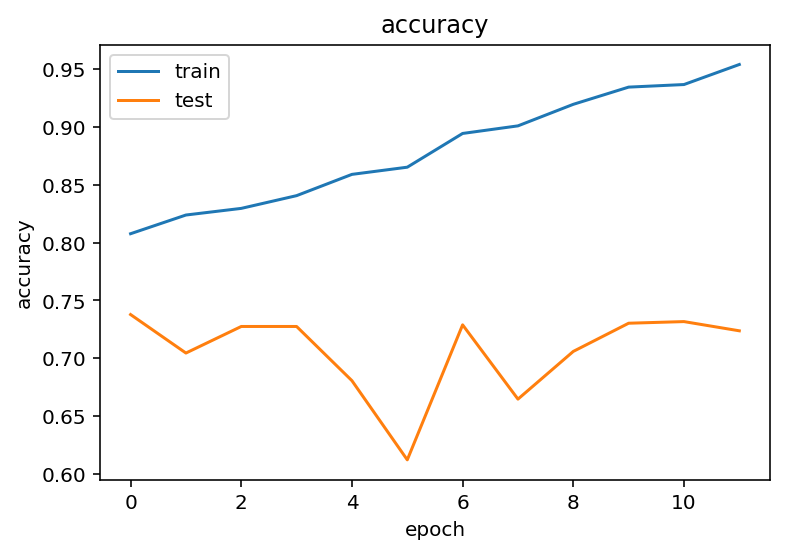

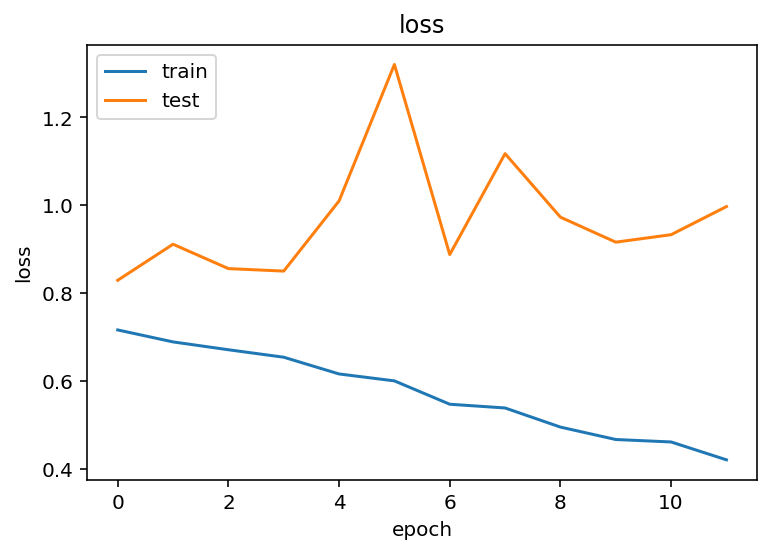

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools, pickle

classes = ["positive", "negative"]

In [29]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
print(classification_report(Y_test, y_pred_class, target_names=classes))

             precision    recall  f1-score   support

   positive       0.69      0.83      0.75      1088
   negative       0.78      0.61      0.68      1044

avg / total       0.73      0.72      0.72      2132



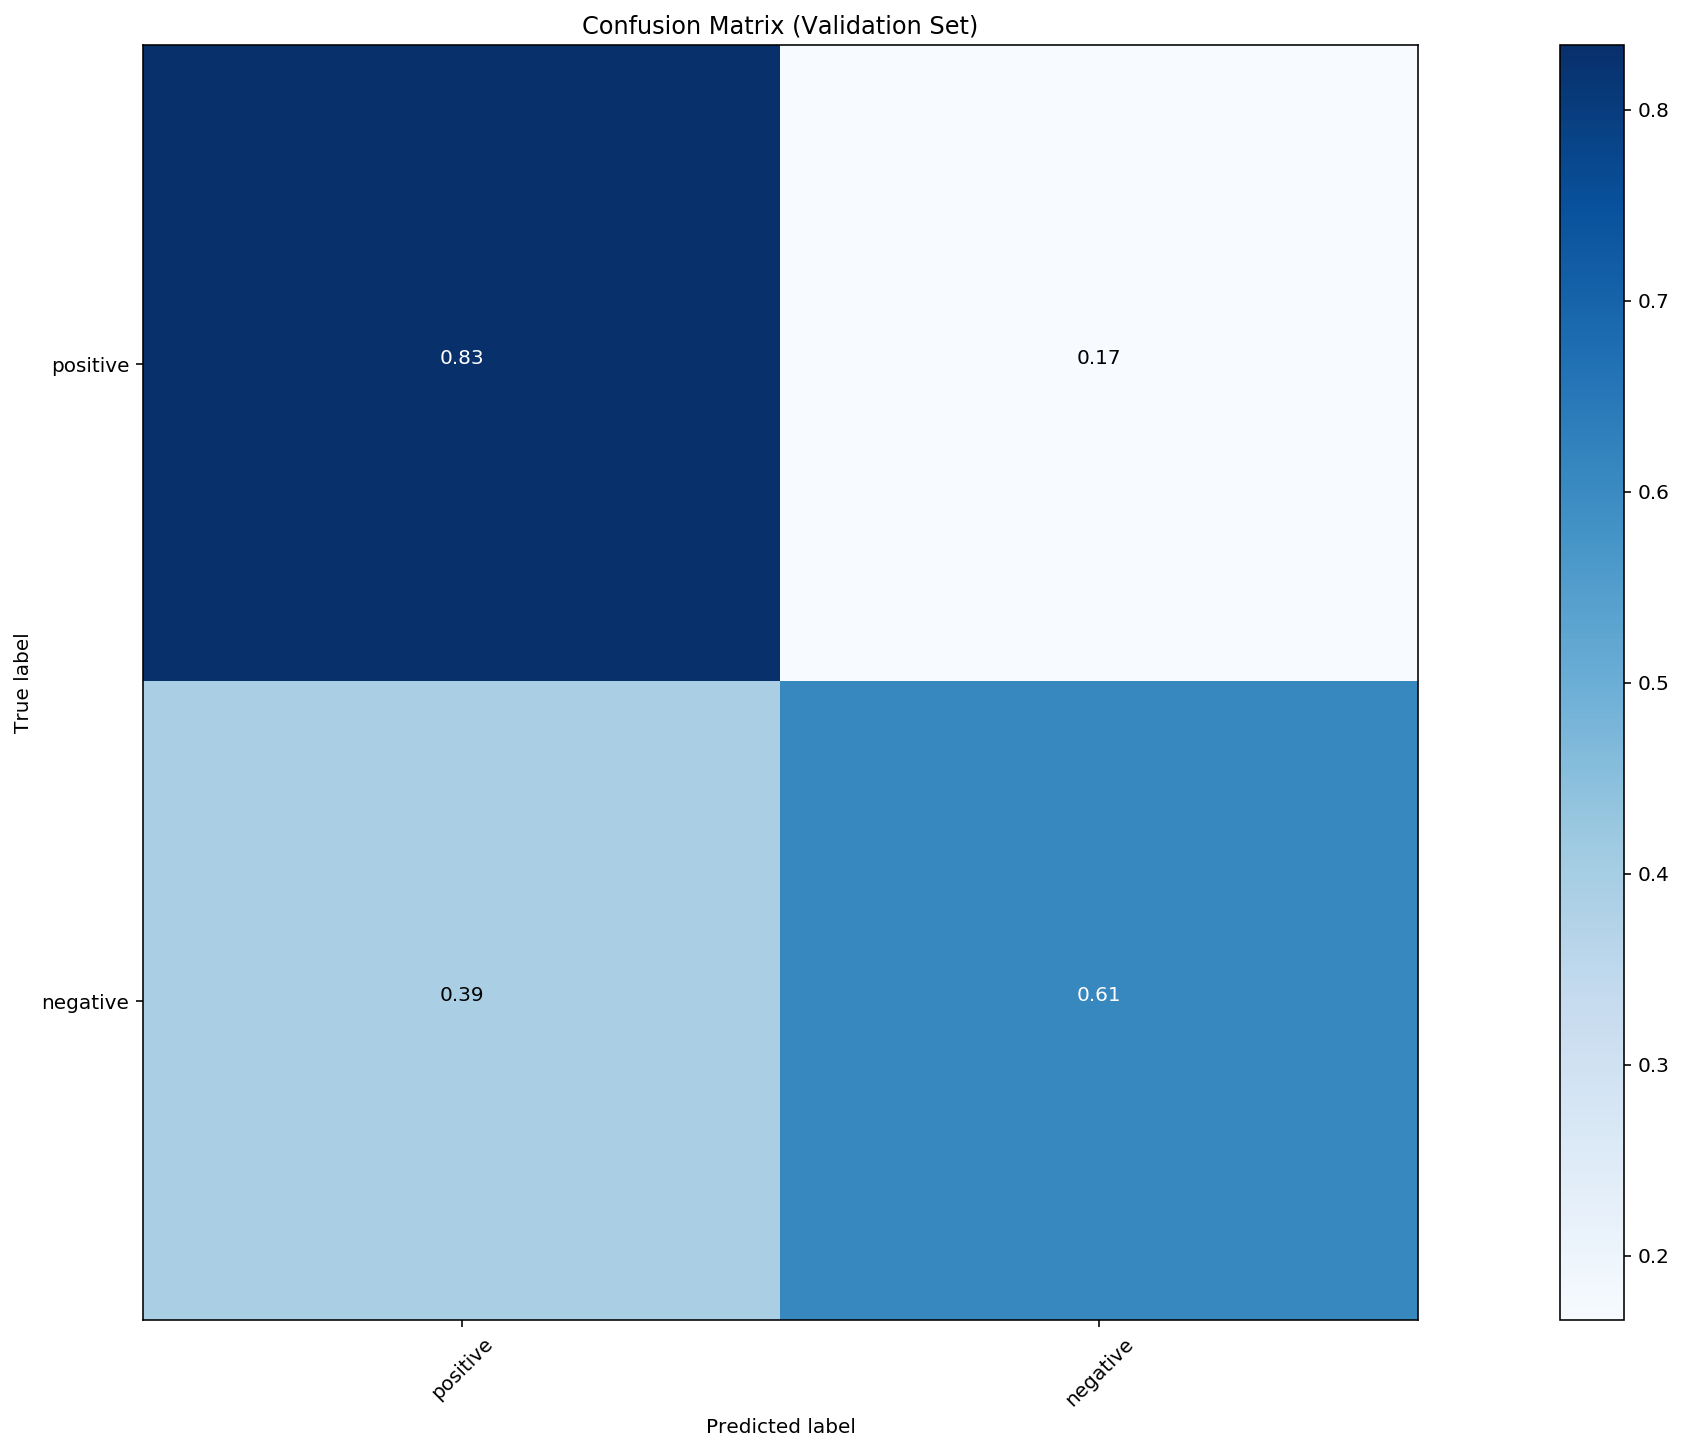

In [30]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)